In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [27]:
#plotting
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Make Covariate File

In [28]:
cov=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
cols=[x for x in cov.columns if "-" not in x]
cov=cov[cols]
cov_male=cov[cov["SEX"]==0]
cov_male=cov_male[~cov_male["FID"].duplicated()]
cov_male.to_csv("../data/UKBB/covariates/cov.tsv",index=None,sep="\t")

## Make Phenotype File

In [29]:
ids=pd.read_csv("../data/UKBB/phenotypes/index.tab")
shbg=pd.read_csv("../data/UKBB/phenotypes/f.30830.tab",delimiter="\t")
pheno=pd.merge(ids,shbg,right_index=True,left_index=True)
test=pd.read_csv("../data/UKBB/phenotypes/f.30850.tab",delimiter="\t")
pheno=pd.merge(pheno,test,right_index=True,left_index=True)

#map IDs
mp=pd.read_csv("../data/UKBB/phenotypes/zUKBiobank_Salem_shared_ID_mapping_file.txt",delim_whitespace=True)
mp=dict(zip(mp["FID_Salem"],mp["FID"]))
pheno["FID"]=pheno["f.eid"].map(mp)

pheno=pheno[pheno["FID"].isin(cov_male["FID"].tolist())]
pheno=pheno[["FID","FID","f.30830.0.0","f.30850.0.0"]]
pheno.columns=["FID","IID","SHBG","Testosterone"]
pheno=pheno.fillna("NA")
pheno.to_csv("../data/UKBB/phenotypes/pheno.tsv",index=None,sep="\t")

In [30]:
pheno[pheno["SHBG"]!="NA"]["SHBG"].std()

16.79814465034584

In [31]:
pheno[pheno["SHBG"]!="NA"]["SHBG"].mean()

39.89883375849533

## Map to X chromosome IDs

In [32]:
mpx=pd.read_csv("../data/UKBB/phenotypes/UKBiobank_genoQC_allancestry_linker.txt",delim_whitespace=True)
mapx=dict(zip(mpx["FID"],mpx["FID_Salem"]))

In [33]:
pheno=pd.read_csv("../data/UKBB/phenotypes/pheno.rank.csv",delimiter="\t")
pheno["FID"]=pheno["FID"].map(mapx)
pheno["IID"]=pheno["IID"].map(mapx)
pheno.to_csv("../data/UKBB/phenotypes/pheno.rank.x.csv",index=None,sep="\t")

In [34]:
cov=pd.read_csv("../data/UKBB/covariates/cov.tsv",delimiter="\t")
cov["FID"]=cov["FID"].map(mapx)
cov["IID"]=cov["IID"].map(mapx)
cov_filt=cov[~cov["FID"].duplicated()]
cov_filt.to_csv("../data/UKBB/covariates/cov.x.tsv",sep="\t",index=None)

### Make PRS

In [35]:
def make_ukbb_prs(compiled_raw, analysis_type, sumstats, snps):
    
    print("{} PRS snps".format(len(snps)))
    
    #keep snps in list
    keep_snps=[]
    
    for x in snps:
        try:
            keep_snps.append([s for s in compiled_raw.columns if x in s][0])
        except:
            pass
    
    compiled_raw = compiled_raw[["IID"]+keep_snps]
    
    #format raw files
    compiled_raw=compiled_raw.set_index("IID")
    compiled_raw=compiled_raw.T
    compiled_raw["min_allele"]=compiled_raw.index.str.split("_").str[-1]
    
    #remove duplicates
    compiled_raw["snp"]=compiled_raw.index.str.split("_").str[0]
    compiled_raw=compiled_raw[~compiled_raw["snp"].duplicated()]
    del compiled_raw["snp"]
    
    compiled_raw.index=compiled_raw.index.str.split("_").str[0]
    
    #reformat summary
    if analysis_type == "logistic":
        summary_merge=sumstats[["rsid","A1","BETA"]].copy()
        summary_merge=summary_merge.drop_duplicates(subset="rsid",keep="first")
        summary_merge=summary_merge.set_index("rsid")
        summary_merge.index=summary_merge.index.str.split("_").str[0]
        
    if analysis_type == "linear":
        summary_merge=sumstats[["rsid","A1","BETA"]].copy()
        summary_merge=summary_merge.drop_duplicates(subset="rsid",keep="first")
        summary_merge=summary_merge.set_index("rsid")
        summary_merge.index=summary_merge.index.str.split("_").str[0]
    
    #annotate the genotypes
    compiled_raw=pd.merge(compiled_raw,summary_merge, left_index=True,right_index=True,how="left")
    print("{} snps missing weight".format(len(compiled_raw[compiled_raw["BETA"].isnull()])))
    
    compiled_raw=compiled_raw[~compiled_raw["BETA"].isnull()] #remove null weights
    compiled_raw["BETA"]=np.where(compiled_raw["min_allele"]!=compiled_raw["A1"],compiled_raw["BETA"]*-1,compiled_raw["BETA"]) #orient the odds ratio
    print("switching {} genotypes".format(len(compiled_raw[compiled_raw["min_allele"]!=compiled_raw["A1"]]))) #number of mismatched genotypes

    del compiled_raw["min_allele"]
    del compiled_raw["A1"]

    #get beta values
    mp_beta=dict(zip(compiled_raw.index,compiled_raw["BETA"]))
    compiled_raw_switch=compiled_raw.iloc[:,:-1].T
    
    #align to all positive snps
    switch_snps=[k for k,v in mp_beta.items() if v < 0]
    
    compiled_raw_switch=compiled_raw_switch.fillna(0)
    
    for x in switch_snps:
        compiled_raw_switch[x]=2-compiled_raw_switch[x]
        
    compiled_raw_switch=compiled_raw_switch.T
    compiled_raw_switch["beta"]=compiled_raw_switch.index.map(mp_beta)
    compiled_raw_switch["beta"]=abs(compiled_raw_switch["beta"])
    compiled_raw_switch=compiled_raw_switch.astype(float)
    
    #compile weighted genotypes
    compiled_raw_switch_out=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0)
    raw_prs=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0).sum(axis=0).reset_index()
    raw_prs.columns=["IID","PRS"]
    
    return(raw_prs)

In [36]:
def combine_raw(direct):
    '''
    combine raw files
    '''
    files=[x for x in os.listdir(direct) if "raw" in x] #get all files
    compiled_df=pd.read_csv(direct+files[0],delimiter="\t")
    for x in files[1:]:
        print(x)
        df=pd.read_csv(direct+x,delimiter="\t")
        compiled_df=pd.merge(compiled_df, df, on=["FID","IID","PAT","MAT","SEX","PHENOTYPE"],how="left")
        
    return(compiled_df)

In [37]:
ukbb_geno=combine_raw("../data/UKBB/genotypes/")

chr22.raw
chr2.raw
chr19.raw
chr10.raw
chr17.raw
chr16.raw
chr11.raw
chr4.raw
chr3.raw
chr9.raw
chr12.raw
chr15.raw
chr7.raw
chr6.raw
chr1.raw
chr14.raw
chr8.raw


In [40]:
sumstats=pd.read_csv("../../data/supplemental/tables5.csv",delimiter="\t")
pheno=pd.read_csv("../data/UKBB/phenotypes/pheno.tsv",delimiter="\t")

In [47]:
len(sumstats[(sumstats["pheno"]=="total")&(sumstats["group"]=="EUR")])

37

In [50]:
sumstats[sumstats["group"]=="EUR"]["pheno"].value_counts()

hypogonad    51
total        37
shbg          7
free          3
Name: pheno, dtype: int64

In [45]:
total_prs=make_ukbb_prs(ukbb_geno, "logistic", sumstats[(sumstats["pheno"]=="total")&(sumstats["group"]=="EUR")], sumstats[(sumstats["pheno"]=="total")&(sumstats["group"]=="EUR")]["rsid"].tolist())
total_prs=pd.merge(total_prs, pheno, on="IID",how="left")

37 PRS snps
0 snps missing weight
switching 28 genotypes


In [65]:
def quantile_plot(df,pheno):
    betas=[]
    errors=[]
    for i in range(10):
        print(i)
        thresh=df["PRS"].quantile(0.1*i)
        df_thresh=df[(df["PRS"]<df["PRS"].quantile(0.1*(i+1)))&(df["PRS"]>df["PRS"].quantile(0.1*i))]
        betas.append(df_thresh[pheno].mean())
        errors.append((df_thresh[pheno].std())/np.sqrt(len(df_thresh)))
    return(betas, errors)

In [66]:
beta, err = quantile_plot(total_prs,"Testosterone")

0
1
2
3
4
5
6
7
8
9


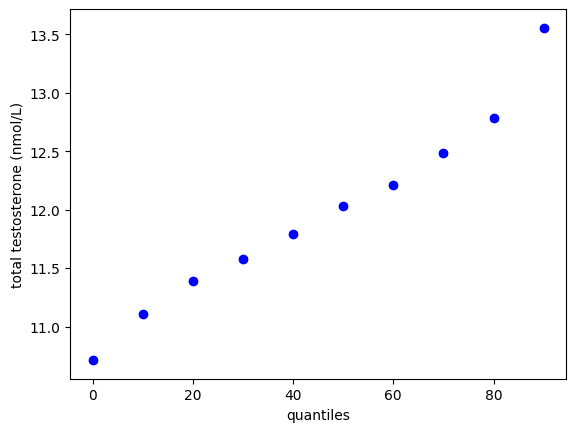

In [67]:
plt.errorbar([x*10 for x in range(10)], beta, yerr=err, fmt='o', elinewidth=3, capsize=3, color="blue")
plt.ylabel("total testosterone (nmol/L)")
plt.xlabel("quantiles")
plt.savefig("total.ukbb.quantile.pdf")

In [68]:
shbg_prs=make_ukbb_prs(ukbb_geno, "logistic", sumstats[(sumstats["pheno"]=="shbg")&(sumstats["group"]=="EUR")], sumstats[(sumstats["pheno"]=="shbg")&(sumstats["group"]=="EUR")]["rsid"].tolist())
shbg_prs=pd.merge(shbg_prs, pheno, on="IID",how="left")

7 PRS snps
0 snps missing weight
switching 5 genotypes


In [69]:
beta, err = quantile_plot(shbg_prs,"SHBG")

0
1
2
3
4
5
6
7
8
9


In [70]:
err

[0.07100395501176844,
 0.06956722223522485,
 0.07712857951843598,
 0.07522013822791511,
 0.07862613671543922,
 0.07690990922796791,
 0.07869012867458491,
 0.07710834252013568,
 0.0817034894915757,
 0.08617192769072764]

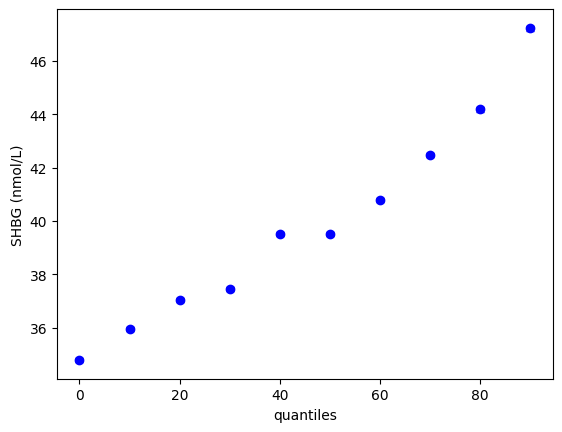

In [71]:
plt.errorbar([x*10 for x in range(10)], beta, yerr=err, fmt='o', elinewidth=3, capsize=3, color="blue")
plt.ylabel("SHBG (nmol/L)")
plt.xlabel("quantiles")
plt.savefig("shbg.ukbb.quantile.pdf")

In [120]:
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/phenotypes/f41202.pheno",delimiter="\t")
eid=pd.read_csv("/cellar/users/mpagadal/data/ukbb/phenotypes/f.eid",delimiter="\t")
icd.index=eid["f.eid"].tolist()

/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [121]:
hypogonad_pts=[]

for x in icd.columns:
    icd_filt=icd[~icd[x].isnull()]
    hypogonad_pts=hypogonad_pts+icd_filt[icd_filt[x].str.contains("E291")].index.tolist()
    
hypogonad_pts=[int(x) for x in hypogonad_pts]

In [95]:
# diabetes_pts=[]

# for x in icd.columns:
#     icd_filt=icd[~icd[x].isnull()]
#     diabetes_pts=diabetes_pts+icd_filt[icd_filt[x].str.contains("E119")].index.tolist()

In [122]:
hypogonad_prs=make_ukbb_prs(ukbb_geno, "logistic", sumstats[(sumstats["pheno"]=="hypogonad")&(sumstats["group"]=="EUR")], sumstats[(sumstats["pheno"]=="hypogonad")&(sumstats["group"]=="EUR")]["rsid"].tolist())

51 PRS snps
0 snps missing weight
switching 28 genotypes


In [133]:
hypogonad_prs["FID"]=hypogonad_prs["IID"].map(mapx).astype(int)

In [124]:
hypogonad_prs["hypogonad"]=np.where(hypogonad_prs["FID"].isin(hypogonad_pts),1,0)

In [125]:
hypogonad_prs=hypogonad_prs[hypogonad_prs["FID"].isin([int(x) for x in cov[cov["SEX"]==0]["FID"].tolist()])]

In [138]:
cov["FID"]=cov["FID"].astype(int)
cov["IID"]=cov["FID"].astype(int)

In [145]:
hypogonad_prs=pd.merge(hypogonad_prs, cov, on="FID",how="left")

In [146]:
import statsmodels.api as sm

In [149]:
odds=[]
se=[]

for i in range(10):
    print(i)
    cases=hypogonad_prs[(hypogonad_prs["PRS"]>hypogonad_prs["PRS"].quantile(.1*i))
                        &(hypogonad_prs["PRS"]<hypogonad_prs["PRS"].quantile(.1*(i+1)))]["FID"].tolist()
    controls=hypogonad_prs[(hypogonad_prs["PRS"]>hypogonad_prs["PRS"].quantile(.5))
                        &(hypogonad_prs["PRS"]<hypogonad_prs["PRS"].quantile(.6))]["FID"].tolist()
    hypogonad_prs_filt=hypogonad_prs[hypogonad_prs["FID"].isin(cases+controls)]
    hypogonad_prs_filt["group"]=np.where(hypogonad_prs_filt["FID"].isin(cases),1,0)

    if i != 5:
        model=sm.OLS(hypogonad_prs_filt["hypogonad"],hypogonad_prs_filt[["group","AGE","PC1","PC2","PC3"]])
        res=model.fit()
        odds.append(np.exp(res.params.tolist()[0]))
        se.append(res.bse.tolist()[0])
    else:
        odds.append(1)
        se.append(0)

0
1


/tmp/ipykernel_1528382/4276980522.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypogonad_prs_filt["group"]=np.where(hypogonad_prs_filt["FID"].isin(cases),1,0)


2
3
4
5
6
7
8
9


In [150]:
len(se)

10

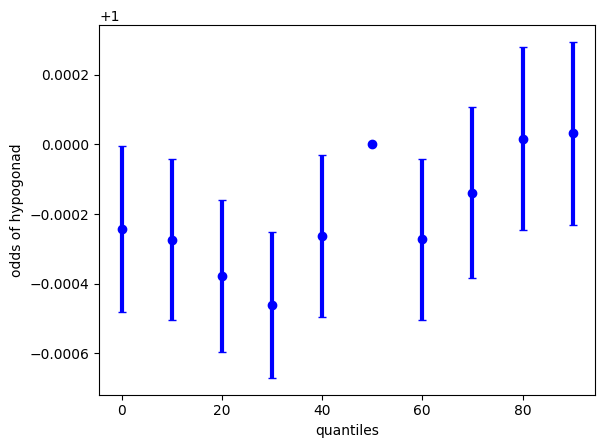

In [151]:
plt.errorbar([x*10 for x in range(0,10)], odds, yerr=se, fmt='o', elinewidth=3, capsize=3,color="blue")
plt.ylabel("odds of hypogonad")
plt.xlabel("quantiles")
plt.savefig("hypogonad.ukbb.quantile.pdf")

In [153]:
top=hypogonad_prs[hypogonad_prs["PRS"]>hypogonad_prs["PRS"].quantile(0.9)]["FID"].tolist()
bottom=hypogonad_prs[hypogonad_prs["PRS"]<hypogonad_prs["PRS"].quantile(0.1)]["FID"].tolist()

In [154]:
hypogonad_prs_filter=hypogonad_prs[hypogonad_prs["FID"].isin(top+bottom)]

In [155]:
hypogonad_prs_filter["top"]=np.where(hypogonad_prs_filter["FID"].isin(top),1,0)

/tmp/ipykernel_1528382/3746849994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypogonad_prs_filter["top"]=np.where(hypogonad_prs_filter["FID"].isin(top),1,0)


In [156]:
model=sm.OLS(hypogonad_prs["hypogonad"],hypogonad_prs[["PRS","AGE","PC1","PC2","PC3"]])
res=model.fit()

In [157]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              hypogonad   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              15.31
Date:                Fri, 05 Jul 2024   Prob (F-statistic):                    4.42e-15
Time:                        20:54:14   Log-Likelihood:                      4.3625e+05
No. Observations:              176210   AIC:                                 -8.725e+05
Df Residuals:                  176205   BIC:                                 -8.724e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PRS         6.003e-05   2.61e-05      2.296      0.022    8.79e-06       0.000
AGE        -6.321e-06   5.89e-06     -1.073      0.283   -1.79e-05    5.22e-06
PC1           -0.0005      0.003     -0.167      0.867      -0.006       0.005
PC2            0.0028      0.003      0.816      0.414      -0.004       0.010
PC3           -0.0040      0.005     -0.750      0.453      -0.015       0.007
==============================================================================
Omnibus:                   548286.453   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      42670501126.294
Skew:                          49.099   Prob(JB):                         0.00
Kurtosis:                    2411.761   Cond. No.                     6.55e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
np.exp(2.279e-05)

1.000022790259694

In [360]:
total_prs["FID"]=total_prs["IID"].map(mapx)
total_prs["diabetes"]=np.where(total_prs["FID"].isin(diabetes_pts),1,0)

In [361]:
total_prs["diabetes"].value_counts()

0    486625
1       784
Name: diabetes, dtype: int64

In [362]:
total_prs=pd.merge(total_prs, cov, on="FID",how="left")

In [363]:
total_prs=total_prs[~total_prs["PC1"].isnull()]

In [364]:
odds=[]
se=[]

for i in range(10):
    print(i)
    cases=total_prs[(total_prs["PRS"]>total_prs["PRS"].quantile(.1*i))
                        &(total_prs["PRS"]<total_prs["PRS"].quantile(.1*(i+1)))]["FID"].tolist()
    controls=total_prs[(total_prs["PRS"]>total_prs["PRS"].quantile(.5))
                        &(total_prs["PRS"]<total_prs["PRS"].quantile(.6))]["FID"].tolist()
    total_prs_filt=total_prs[total_prs["FID"].isin(cases+controls)]
    total_prs_filt["group"]=np.where(total_prs_filt["FID"].isin(cases),1,0)

    if i != 5:
        model=sm.OLS(total_prs_filt["diabetes"],total_prs_filt[["group","AGE","PC1","PC2","PC3"]])
        res=model.fit()
        odds.append(np.exp(res.params.tolist()[0]))
        se.append(res.bse.tolist()[0])
    else:
        odds.append(1)
        se.append(0)

0
1
2


<ipython-input-364-3ce87995c406>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_prs_filt["group"]=np.where(total_prs_filt["FID"].isin(cases),1,0)


3
4
5
6
7
8
9


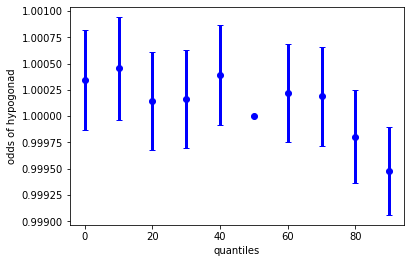

In [365]:
plt.errorbar([x*10 for x in range(0,10)], odds, yerr=se, fmt='o', elinewidth=3, capsize=3,color="blue")
plt.ylabel("odds of hypogonad")
plt.xlabel("quantiles")
plt.savefig("diabetes.total.ukbb.quantile.pdf")

In [366]:
model=sm.OLS(total_prs["diabetes"],total_prs[["PRS","AGE","PC1","PC2","PC3"]])
res=model.fit()

In [367]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               diabetes   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              78.65
Date:                Thu, 20 Jul 2023   Prob (F-statistic):                    1.05e-82
Time:                        23:58:37   Log-Likelihood:                      2.9639e+05
No. Observations:              176241   AIC:                                 -5.928e+05
Df Residuals:                  176236   BIC:                                 -5.927e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PRS           -0.0007      0.000     -3.104      0.002      -0.001      -0.000
AGE          7.26e-05   1.18e-05      6.135      0.000    4.94e-05    9.58e-05
PC1           -0.0078      0.006     -1.227      0.220      -0.020       0.005
PC2            0.0142      0.008      1.866      0.062      -0.001       0.029
PC3           -0.0096      0.012     -0.808      0.419      -0.033       0.014
==============================================================================
Omnibus:                   399169.469   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1756657249.497
Skew:                          22.113   Prob(JB):                         0.00
Kurtosis:                     490.094   Cond. No.                     6.40e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [368]:
np.exp(-0.0007)

0.9993002449428433